
# Analysis Notebook

This notebook can be used to produce graphs and analyses for the data produced. It defaults to using the latest results, but that can be specified. 
*** 

## 0. Setup
This section imports all files and sets up the notebook.

In [31]:
# Import all pacakges
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import nan

import src.utils as utils


In [32]:
# Choose which results to use
file_to_use = ""  # If this is empty, the last file in the folder will be used
last_file = sorted(os.listdir('results/'))[-1]

if file_to_use == "":
    file_to_use = last_file

print("Using file: " + file_to_use)


Using file: 2023-06-16_19-45-03


In [33]:
# Import the .csvs and create dataframes
# read txt file
sim_confifiguration = pd.read_csv(
    'results/' + file_to_use + '/configuration.txt', header=None, delimiter=":")
display(sim_confifiguration)  # Display the configuration


,0,1
0,command,run
1,num_of_epochs,2
2,num_of_simulations,100
3,grid_size,3
4,queue_capacity,5
5,congestion_rate,0.1
6,credit_balance,100
7,wage_time,5
8,auction_modifier_type,spsa
9,intersection_reward,time


***

## 1. Satisfaction per Bidding Type

In [34]:
# Load relevant data:
average_satisfaction_score_by_bidding_type = pd.read_csv(
    'results/' + file_to_use + '/average_satisfaction_score_by_bidding_type.csv')


In [35]:
def plot_satisfaction_scores_by_bidding_type(data, with_std=False, epochs_range=[]):
    """Creates a graph of the average satisfaction score per epoch, optionally with error bars, averaged over all simulations,
        for each bidding type, represented by a different color.
    Args:
        data (pd.DataFrame): The dataframe containing the data to plot
        with_std (bool): Whether to include the standard deviation in the plot
    """
    # Get the columns with the satisfaction scores
    satisfaction_score_columns = [
        col for col in data.columns if 'Score' in col]
    epochs = data['# Epoch']

    # Create a figure, with epochs on the x axies and satisfaction scores on the y axis
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Satisfaction Score')
    ax.set_title('Average Satisfaction Score per Epoch')

    # For each bidding type, plot the average satisfaction score per epoch
    for col in satisfaction_score_columns:
        if with_std:
            ax.errorbar(epochs, data[col], data[col + ' SD'], label=col)
        else:
            ax.plot(epochs, data[col], label=col,
                    marker='o', linestyle='None', markersize=1.5)
    ax.legend()

    # Set the range of the x axis
    if len(epochs_range) > 0:
        ax.set_xlim(epochs_range[0], epochs_range[1])

    plt.show()
    plt.clf()


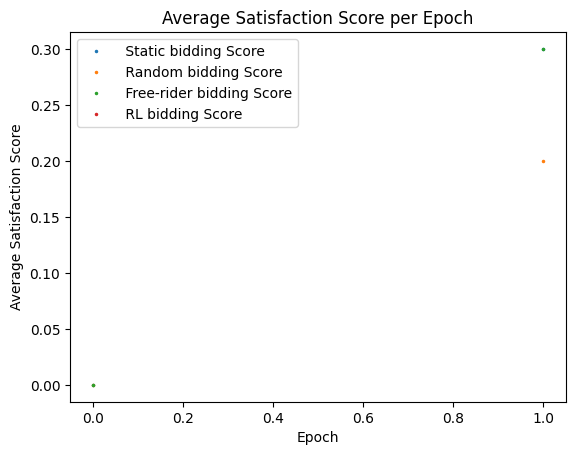

<Figure size 640x480 with 0 Axes>

In [36]:
plot_satisfaction_scores_by_bidding_type(
    average_satisfaction_score_by_bidding_type, epochs_range=[])


***

## 2. Heatmap of Throughput per Intersection

In [37]:
# Load relevant data:
average_throughput_per_intersection = pd.read_csv(
    'results/' + file_to_use + '/average_throughput_per_intersection.csv', header=None)


In [38]:
def plot_throughput_heatmap_average(data):
    """Creates a heatmap of the average throughput per intersection.
    Args:
        data (pd.DataFrame): The dataframe containing the data to plot
    """
    ax = sns.heatmap(data, annot=True)
    ax.set(xlabel='X coordinate', ylabel='Y coordinate',
           title='Average throughput per intersection')
    plt.show()
    plt.clf()


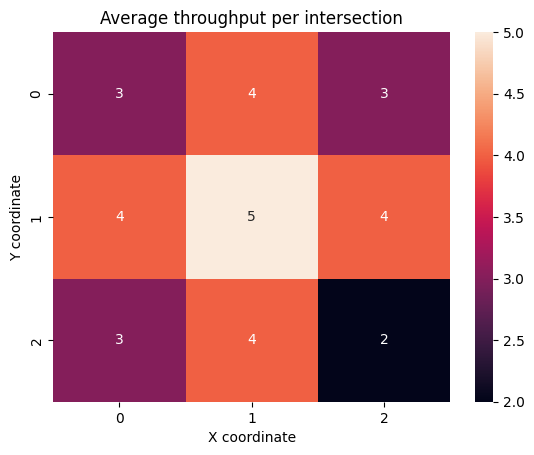

<Figure size 640x480 with 0 Axes>

In [39]:
plot_throughput_heatmap_average(average_throughput_per_intersection)


## Average Reward per Intersection

In [40]:
average_reward_per_intersection_df = pd.read_csv(
    'results/' + file_to_use + '/average_reward_per_intersection_history.csv')
num_of_intersections = int(
    np.sqrt(len(average_reward_per_intersection_df.columns)))
# convert 2d array to 3d array with shape (num_of_intersections, num_of_intersections, num_of_epochs)
average_reward_per_intersection = np.array(average_reward_per_intersection_df).reshape(
    num_of_intersections, num_of_intersections, -1)


array([[[0.  , 0.  ],
        [0.  , 0.  ],
        [0.  , 0.  ]],

       [[0.  , 0.  ],
        [0.  , 0.86],
        [0.94, 0.77]],

       [[0.91, 0.98],
        [0.93, 0.8 ],
        [0.84, 0.75]]])

In [41]:
def plot_reward_per_intersection_history(data):
    # Create a plot with subplots for each intersection. Each subplot is a graph of the reward history of that intersection. In total there are as many subplots as intersections
    fig, axs = plt.subplots(
        data.shape[0], data.shape[1], sharex=True, sharey=True, figsize=(20, 20))
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            axs[i, j].plot(average_reward_per_intersection[i, j])
            axs[i, j].set_title('[' + str(i) + str(j) + ']')
            axs[i, j].set_xlabel('Epoch')
            axs[i, j].set_ylabel('Average Reward')
    plt.show()
    plt.clf()


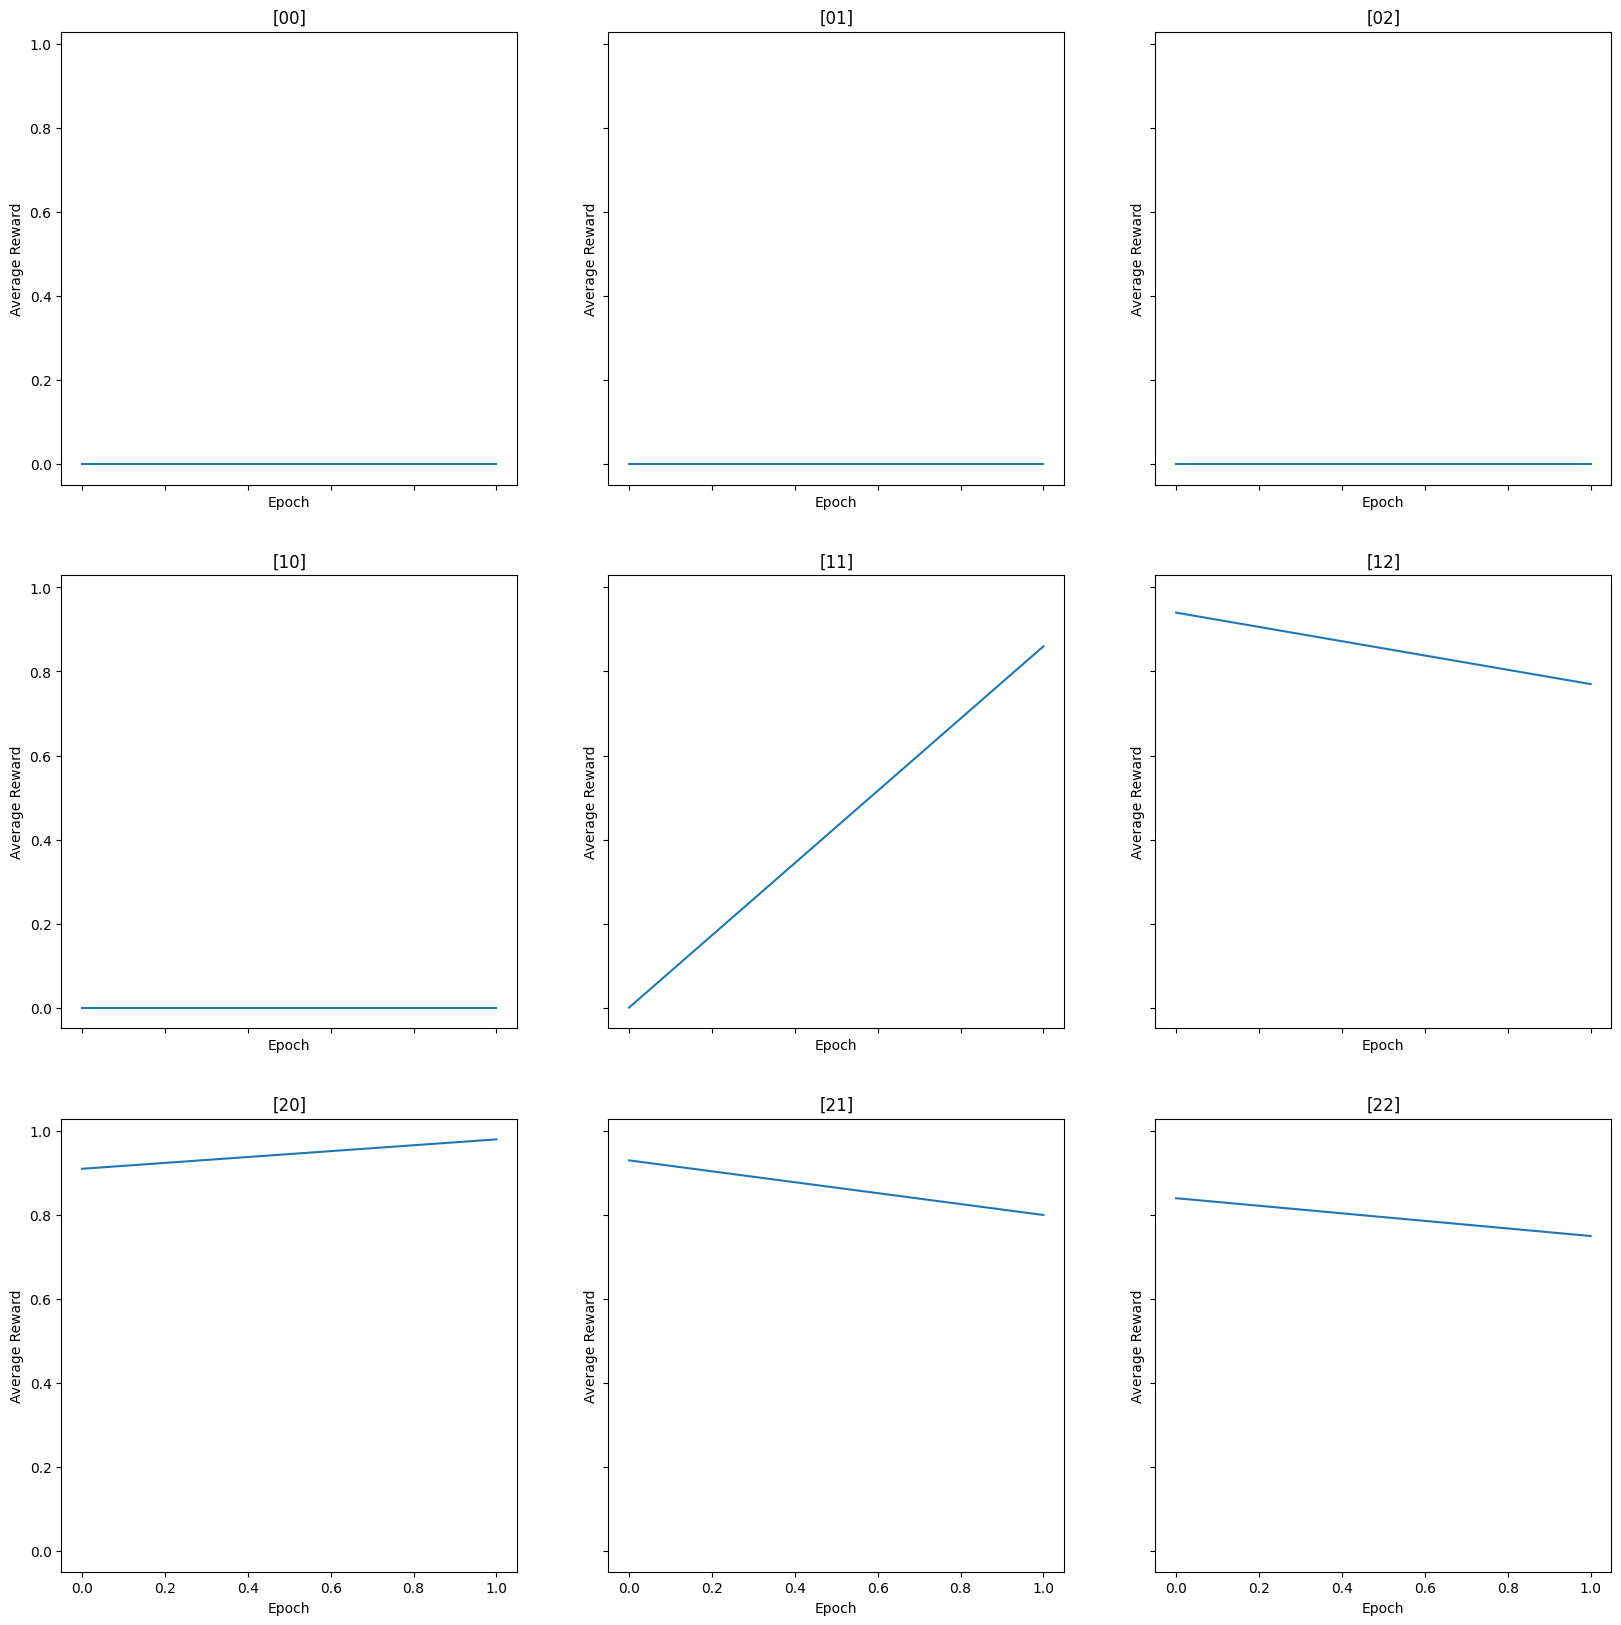

<Figure size 640x480 with 0 Axes>

In [42]:
plot_reward_per_intersection_history(average_reward_per_intersection)
